In [1]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
new_battery_Z = "./Battery_Data/new_battery_cycles/Battery_RNN_from_prior_mse_v4_part_10.mdl"
degraded_battery_Z = "./Battery_Data/degraded_battery_cycles/Battery_RNN_from_new_mse_v1_part_4.mdl"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)


Current_min = -0.000520787
Current_max = 6.74372

In [5]:
class Polarising_Impedance_Map(nn.Module):
    def __init__(self):
        super(Polarising_Impedance_Map, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)

    def forward(self, soc_prior, current_prior):

        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        return Z

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Z_pol_new = Polarising_Impedance_Map()
Z_pol_new.load_state_dict(torch.load(new_battery_Z))
Z_pol_new.to(device)
Z_pol_old = Polarising_Impedance_Map()
Z_pol_old.load_state_dict(torch.load(degraded_battery_Z))
Z_pol_old.to(device)
soc_map = np.array(np.linspace(0, 1.0, 1000), ndmin=2)

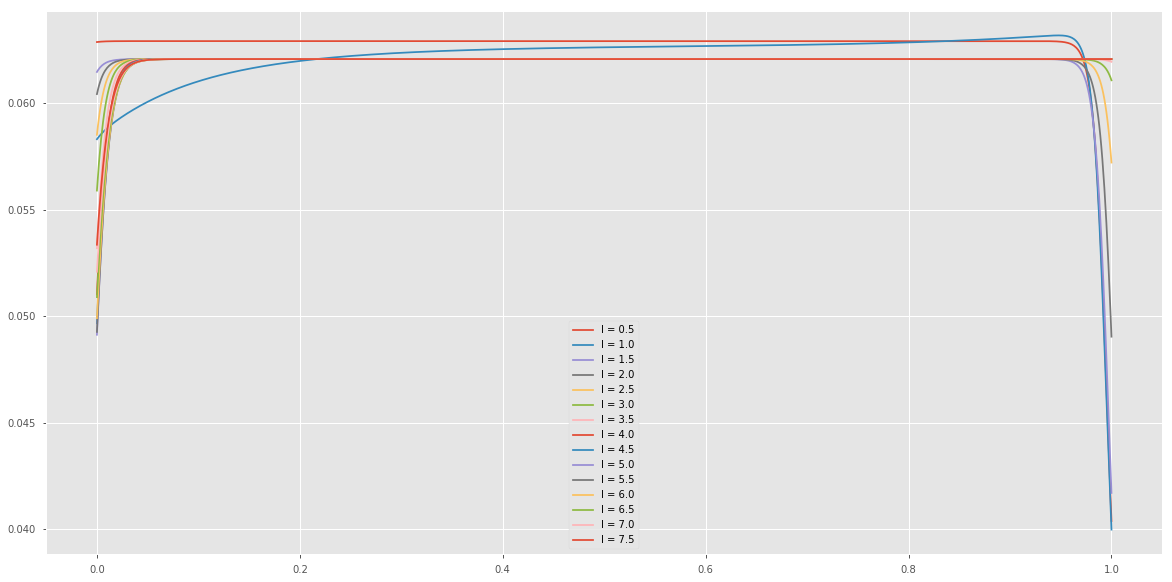

In [7]:
Z_map = []
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure()
for i in range(1, 16):
    with torch.no_grad():
        Z = Z_pol_new(soc_map.T, np.ones((1000, 1))*float(i/2.0))
        Z_map.append(Z.cpu().numpy())
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i/2.0))
plt.legend()
plt.show()

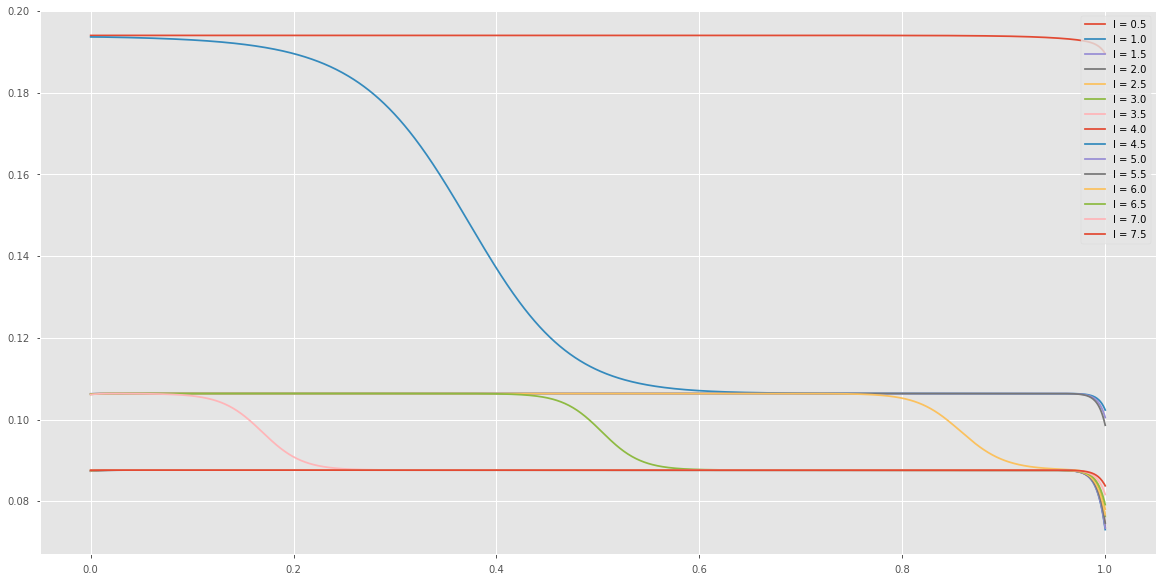

In [8]:
Z_map = []
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure()
for i in range(1, 16):
    with torch.no_grad():
        Z = Z_pol_old(soc_map.T, np.ones((1000, 1))*float(i/2.0))
        Z_map.append(Z.cpu().numpy())
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i/2.0))
plt.legend()
plt.show()

(100, 1000)


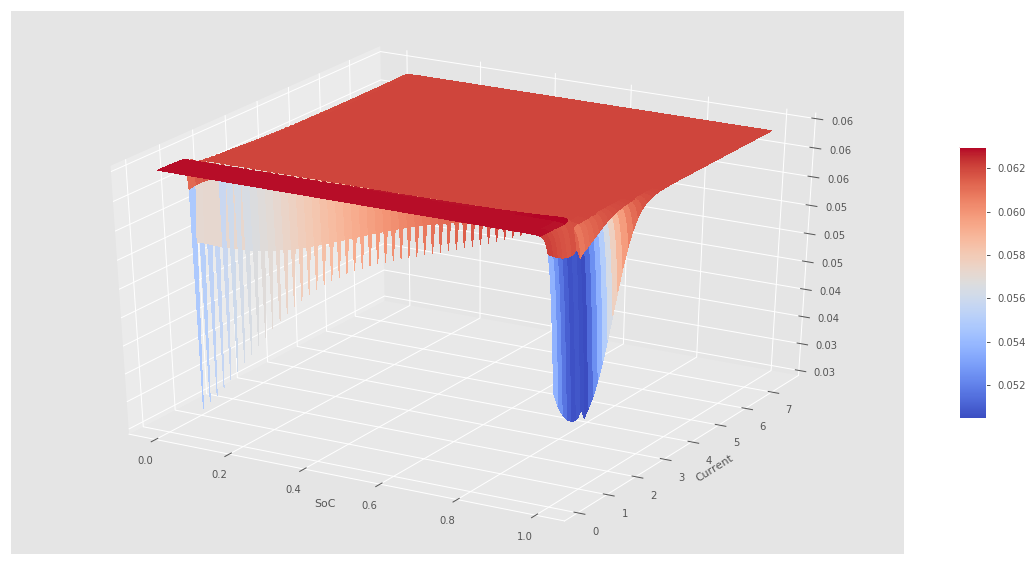

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = soc_map
Y = np.linspace(0.1, 7.5, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol_new(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel("SoC")
plt.ylabel("Current")

plt.show()

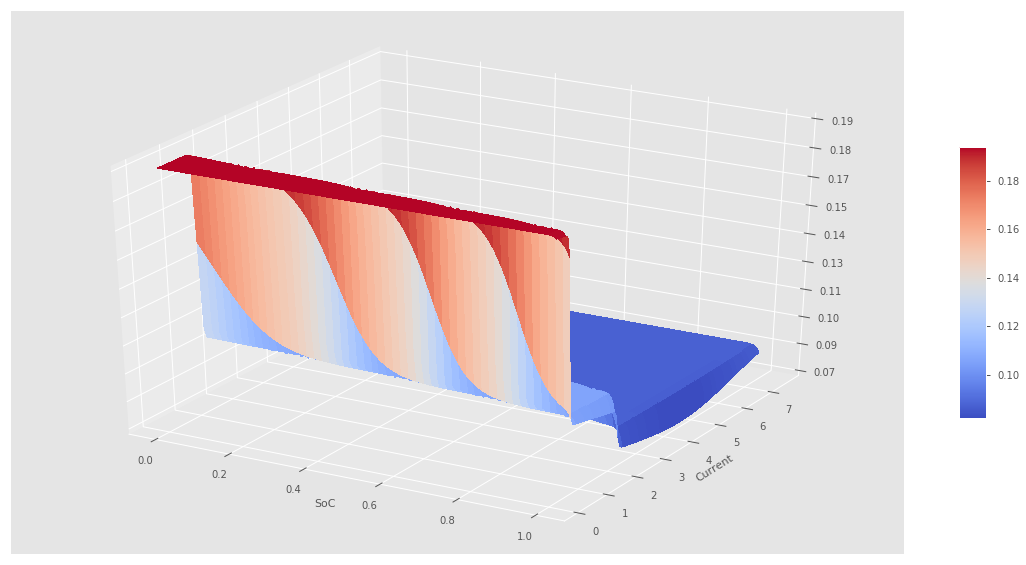

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = soc_map
Y = np.linspace(0.1, 7.5, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol_old(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel("SoC")
plt.ylabel("Current")

plt.show()